1. Thư viện cần dùng

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2. Chuẩn bị dữ liệu

In [19]:
# Đọc dữ liệu
df = pd.read_csv(r"dataset.csv", parse_dates=['date'])

# ==== 2. Time features ====
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

#df['dayofyear'] = df['date'].dt.dayofyear
#df['weekofyear'] = df['date'].dt.isocalendar().week

#df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# ==== 3. Spike and volatility features ====
df['aqi_diff'] = df['AQI'].diff().fillna(0)
df['aqi_rolling_std'] = df['AQI'].rolling(window=5).std().fillna(0)
diff_abs = df['AQI'].diff().abs()
df['spike_flag'] = ((diff_abs > 225) | (diff_abs < 75)).astype(int)

# ==== 4. Feature selection ====
features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2','CO',
            'day_sin','day_cos', 'month_sin','month_cos', 'quarter_sin', 'quarter_cos', 'aqi_diff', 'aqi_rolling_std']
            #,'aqi_diff', 'aqi_rolling_std', 'dayofyear', 'weekofyear', 'is_weekend']
target = 'AQI'

# ==== 5. Scaling ====
X_scaler = StandardScaler()
y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(df[features])
scaled_y = y_scaler.fit_transform(df[[target]])

scaled_df = pd.DataFrame(scaled_X, columns=features)
scaled_df['AQI'] = scaled_y
scaled_df['spike_flag'] = df['spike_flag'].values

3. Tạo tập dữ liệu chuỗi (sliding window)

In [20]:
def create_sequences(data, features, target, window_size):
    X, y, sw = [], [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size][features].values)
        y.append(data.iloc[i+window_size][target])
        sw.append(data.iloc[i+window_size]['spike_flag'] * 9 + 1 )  # spike weight = 10, normal = 1
    return np.array(X), np.array(y), np.array(sw)

window_size = 7
X, y, sample_weights = create_sequences(scaled_df, features, 'AQI', window_size)



4. Chia tập train/test

In [21]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
sw_train = sample_weights[:split_index]

5. Xây dựng mô hình

In [22]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.initializers import RandomNormal


model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='relu', dropout=0.3,
              input_shape=(X.shape[1], X.shape[2]), kernel_initializer='orthogonal', bias_initializer = RandomNormal(mean=0.0, stddev=0.05)),
    #Dense(128),
    SimpleRNN(128, return_sequences=True, activation='tanh', dropout=0.25, kernel_initializer='orthogonal', bias_initializer = RandomNormal(mean=0.0, stddev=0.4)),
    #Dense(64),
    SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.2, kernel_initializer='orthogonal', bias_initializer = RandomNormal(mean=0.0, stddev=0.4)),
    #Dense(32),
    SimpleRNN(32, return_sequences= True, activation='linear', dropout=0.1, kernel_initializer='orthogonal'),
    Dense(16),
    SimpleRNN(16, activation='relu', dropout=0.05, kernel_initializer='orthogonal', bias_initializer = RandomNormal(mean=0.0, stddev=0.05)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=10.0), metrics=['mse'])
model.summary()


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 7, 256)         │        69,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 7, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 7, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 7, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,185 (528.07 KB)

 Trainable params: 135,185 (528.07 KB)

 Non-trainable params: 0 (0.00 B)

6. Huấn luyện mô hình

In [23]:
# Dừng sớm nếu không cải thiện trong 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    sample_weight=sw_train,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 6.6456 - mse: 1.3706 - val_loss: 1.8003 - val_mse: 0.3910
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2171 - mse: 0.7026 - val_loss: 1.9849 - val_mse: 0.4305
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8789 - mse: 0.6144 - val_loss: 1.2789 - val_mse: 0.2893
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6067 - mse: 0.5619 - val_loss: 1.2203 - val_mse: 0.2731
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8825 - mse: 0.4534 - val_loss: 1.3904 - val_mse: 0.3121
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9942 - mse: 0.4541 - val_loss: 1.3498 - val_mse: 0.3039
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8619 - mse: 0.4035 - val_loss: 1.1421 - val_mse: 0.2626
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6664 - mse: 0.3740 - val_loss: 1.0076 - val_mse: 0.2330
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - lo

7. Đánh giá mô hình

In [24]:
# Dự đoán và nghịch chuẩn hoá
y_pred = model.predict(X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
MAE: 14.52
RMSE: 20.66
R²: 0.69


MAE : sai số trung bình tuyệt đối giữa giá trị dự đoán và giá trị thực tế.
RMSE(Root Mean Squared Error) : sai số bình phương trung bình (và sau đó lấy căn bậc 2)
R^2 (R-squared) : Đo mức độ mô hình giải thích được phương sai của dữ liệu thực.

7. Trực quan hóa kết quả

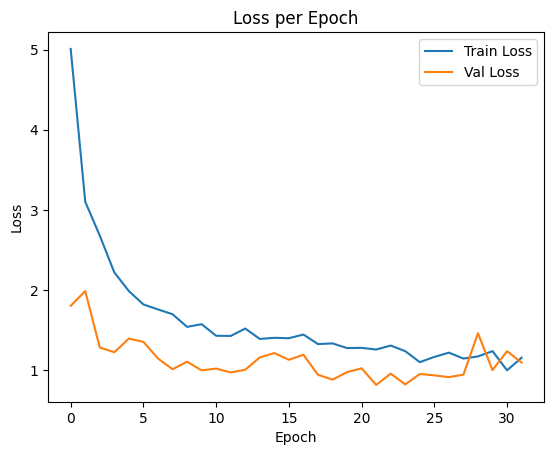

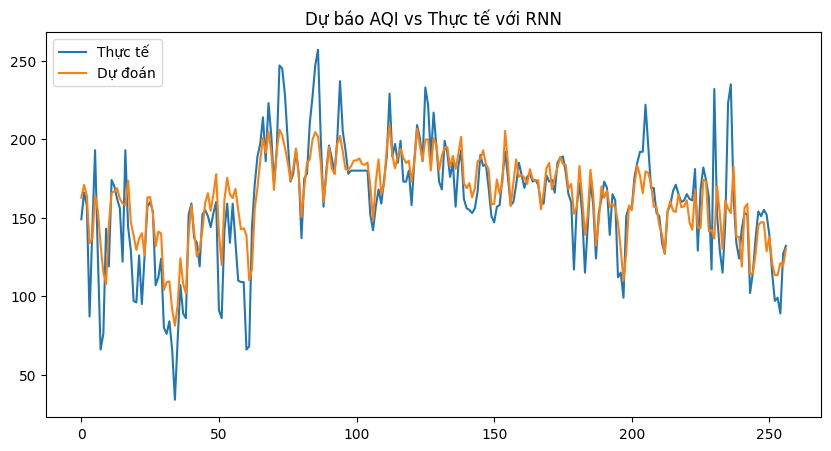

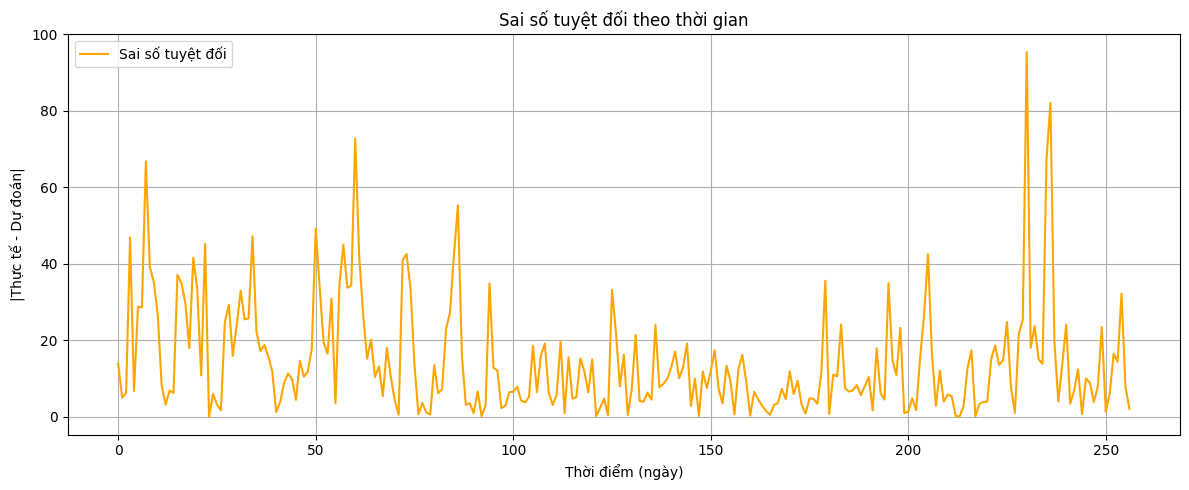

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Vẽ kết quả
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(y_pred_inv, label='Dự đoán')
plt.legend()
plt.title("Dự báo AQI vs Thực tế với RNN")
plt.show()

absolute_error = np.abs(y_test_inv.flatten() - y_pred_inv.flatten())

plt.figure(figsize=(12, 5))
plt.plot(absolute_error, label='Sai số tuyệt đối', color='orange')
plt.title("Sai số tuyệt đối theo thời gian")
plt.xlabel("Thời điểm (ngày)")
plt.ylabel("|Thực tế - Dự đoán|")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

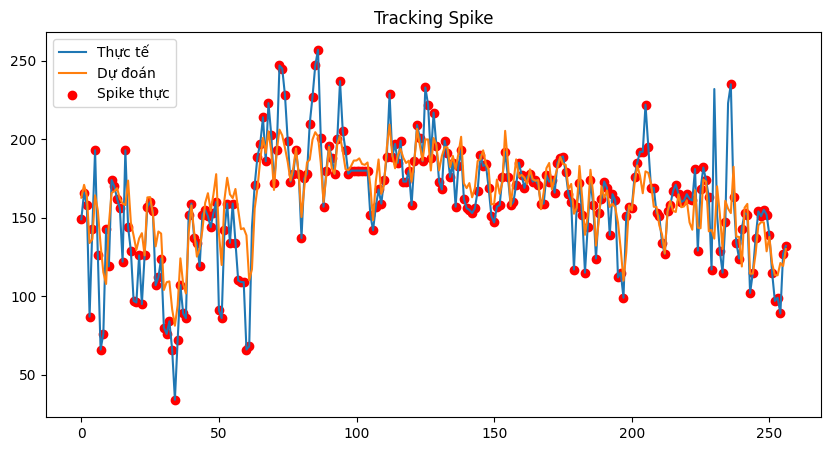

In [26]:
spike_indices = np.where(df['spike_flag'].values[window_size+split_index:] == 1)[0]
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(y_pred_inv, label='Dự đoán')
plt.scatter(spike_indices, y_test_inv[spike_indices], color='red', label='Spike thực')
plt.title("Tracking Spike")
plt.legend()
plt.show()


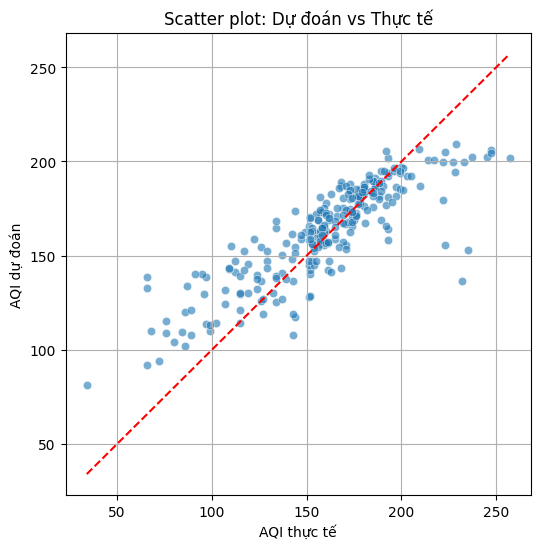

In [27]:
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv.flatten(), alpha=0.6)
plt.xlabel("AQI thực tế")
plt.ylabel("AQI dự đoán")
plt.title("Scatter plot: Dự đoán vs Thực tế")
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='red', linestyle='--')  # đường y=x
plt.grid(True)
plt.show()